In [1]:
import os
import sys
import math
import json
import gc
import datetime
from tqdm import tqdm
from collections import defaultdict
from typing import List
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy.signal import find_peaks
from scipy.stats import zscore
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_theme(style="white")
from adjustText import adjust_text
import cv2
import scanpy as sc
import anndata as ad
import stlearn as st
import statsmodels.api as sm
import skbio
from skbio.stats.ordination import pcoa
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as hc
from scipy.cluster.hierarchy import linkage, dendrogram, ClusterNode, to_tree

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
file_ = "./dataset/outs/"

In [3]:
adata = st.ReadXenium(feature_cell_matrix_file=f"{file_}/cell_feature_matrix.h5",
                      cell_summary_file=f"{file_}/cells.csv.gz",
                      library_id="Case7_After",
                      image_path=None,
                      scale=1,
                      spot_diameter_fullres=10 # Recommend
                     )

In [4]:
# Gridding at 10μm interval using stlearn
N_COL = int((adata.obs.imagecol.max() - adata.obs.imagecol.min()) / 10)
N_ROW = int((adata.obs.imagerow.max() - adata.obs.imagerow.min()) / 10)
grid = st.tl.cci.grid(adata, n_row=N_ROW, n_col=N_COL, n_cpus=48, verbose=False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
from preparation.skny_calc_distance import calculate_distance

In [6]:
## apply SKNY
grid = calculate_distance(
    grid, pos_marker_ls=['CDH1',"EPCAM"],
)

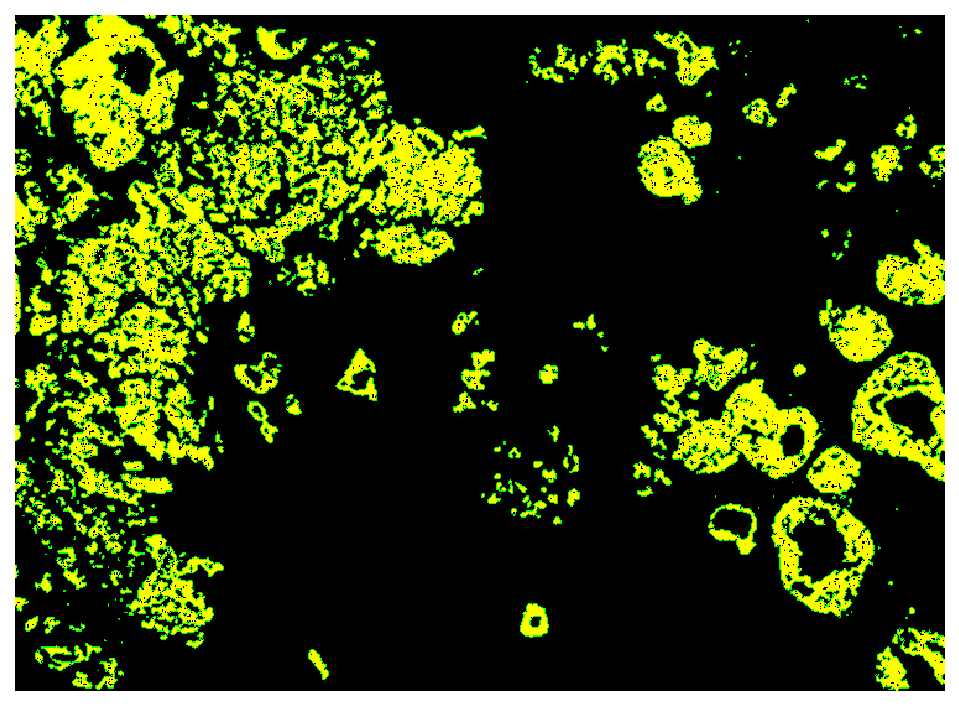

In [7]:
# Figure 2B
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.imshow(cv2.cvtColor(grid.uns["marker_median_delineation"], cv2.COLOR_BGR2RGB),
          interpolation="nearest")
ax.axis("off")
plt.show()

#plt.savefig("Figure_2B.png", dpi=300)

In [8]:
# annotation each section to obs object
df_shotest = getattr(grid, "shortest")
df_grid = grid.to_df()

# extract grid info
df_grid = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]),
    df_grid, right_index=True, left_index=True, how="left"
).fillna(np.nan)

# extract section info
df_region = pd.DataFrame(
    np.array(df_shotest["region"]).reshape(N_ROW, N_COL).T.reshape(N_ROW * N_COL),
    index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)], columns=["region"]
)

# marge
df_grid_region = pd.merge(
    df_grid, df_region,
    right_index=True, left_index=True, how="left"
)
df_grid_region = df_grid_region.dropna()

# add to obs
grid.obs = pd.merge(
    grid.obs, df_grid_region[["region"]],
    right_index=True, left_index=True, how="left"
)

# shaping
grid.obs["region_10"] = [str(i*10) for i in grid.obs["region"]]
grid.obs["region_10"] = ["("+str(int(float(i.split(", ")[0][1:])))+", "+str(int(float(i.split(", ")[-1][:-1])))+"]" if i != "nan" else np.nan for i in grid.obs["region_10"]]
# exclude because of small number
grid.obs["region_10"] = grid.obs["region_10"].replace(
    {"(-150, -120]": np.nan}
)

In [9]:
from preparation.choose_roi import extract_roi, contour_regions

In [10]:
# select ROI
roi = (2400, 3400, 2400, 3800)

subset_grid, filtered_shortest, xy_list = extract_roi(
    grid=grid,
    roi=roi,
    bin_size=10,
    region_col="region_10",
)


In [11]:
g_x_cont, g_y_cont, g_x_inside, g_y_inside = contour_regions(
    filtered_shortest, adata,
    min_x=0, max_x=4000, min_y=0, max_y=4000,
    out_dir_base="./roi_plots",
    show=False,
)


In [12]:
from preparation.scomv_calc_vector import compute_min_vectors_polar

outline_points = list(zip(g_x_cont, g_y_cont))
inside_points  = list(zip(g_x_inside, g_y_inside))

min_vector_df = compute_min_vectors_polar(
    xy_list=xy_list,
    outline_points=outline_points,
    inside_points=inside_points,
    invert_y=True,
    make_inside_negative=True,
)

In [13]:
# load cell_annotation file
file_path = "./dataset/Cell_Barcode_Type_Matrices.xlsx"

xls = pd.ExcelFile(file_path)
# read 4th page
cell_ann_df = pd.read_excel(file_path, sheet_name=xls.sheet_names[3])
print(cell_ann_df.head())

adata_obs = adata.obs

#adata_obs = adata.obs
cell_ann_df.index = cell_ann_df.index + 1
adata_obs = adata_obs[["imagecol", "imagerow"]]
adata_obs.index = adata_obs.index.astype(int)


cell_df = pd.concat([adata_obs, cell_ann_df], axis=1)
cell_df = cell_df[["imagecol", "imagerow", "Cluster"]]
cell_df["Cluster"].unique()
#cell_df.to_csv("cell_annotation_df.csv")

   Barcode         Cluster
0        1          DCIS_2
1        2          DCIS_2
2        3       Unlabeled
3        4  Invasive_Tumor
4        5          DCIS_2


array(['DCIS_2', 'Unlabeled', 'Invasive_Tumor', 'Macrophages_1',
       'Stromal', 'DCIS_1', 'Myoepi_ACTA2+', 'CD8+_T_Cells',
       'Endothelial', 'Prolif_Invasive_Tumor', 'T_Cell_&_Tumor_Hybrid',
       'Mast_Cells', 'CD4+_T_Cells', 'B_Cells', 'Macrophages_2',
       'Stromal_&_T_Cell_Hybrid', 'Perivascular-Like', 'LAMP3+_DCs',
       'IRF7+_DCs', 'Myoepi_KRT15+'], dtype=object)

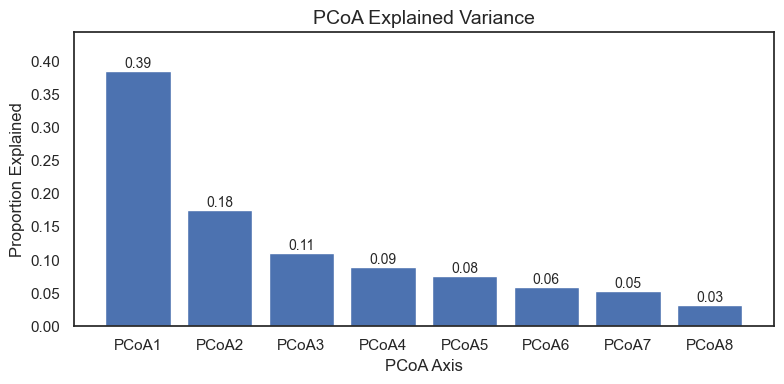

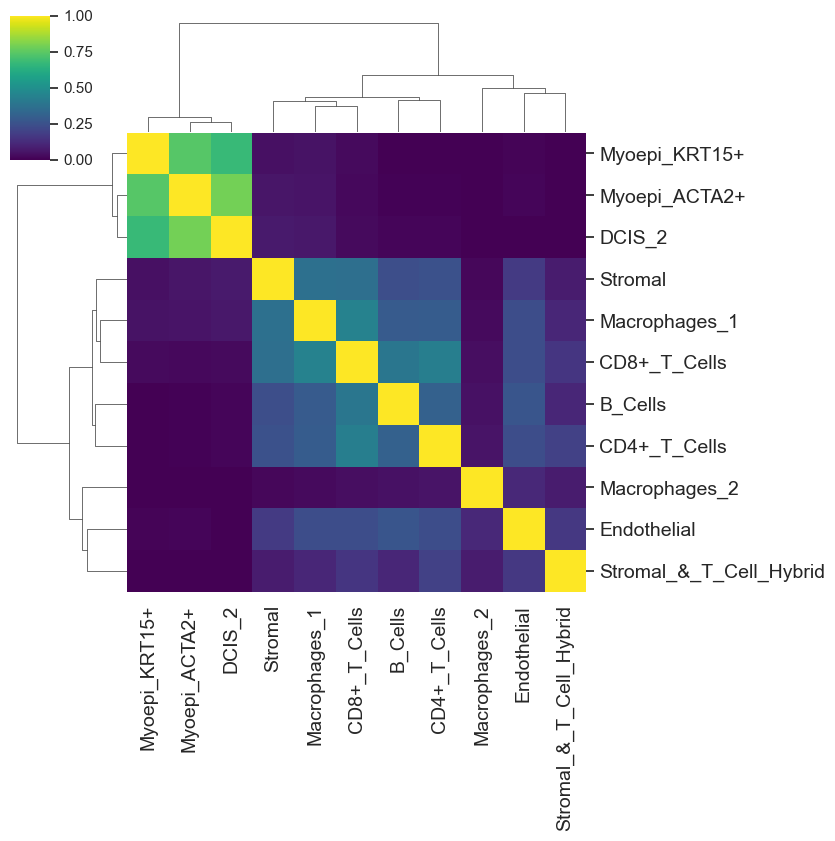

In [14]:
from cell_pipeline import CellPolarPipeline

# Initialize the pipeline with cell-level data and precomputed minimum-distance vectors
cell_pipe = CellPolarPipeline(
    cell_df=cell_df,
    min_vector_df=min_vector_df
)

# Run the pipeline for a specified ROI (xmin, xmax, ymin, ymax)
# Disable histogram plotting during the run
cell_out = cell_pipe.run(
    roi=(2400, 3400, 2400, 3800),
    plot_hist=False
)

# Distance matrix between cells based on polar-vector representations
dist = cell_pipe.dist_df

# Plot explained variance of PCoA components
cell_pipe.plot_explained_variance(n_components=8)

# Plot a heatmap of similarities (displayed as 1 - distance)
cell_pipe.heatmap(font_size=14, figsize=(8, 8))


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:859: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


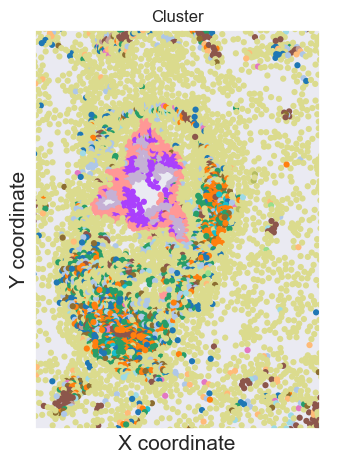

In [15]:
import anndata

bdata = anndata.AnnData(X=np.zeros((len(cell_df), 0)))  # Dummy X
bdata.obs = cell_df.copy()

# Store the coordinates used as the basis in adata.obsm
bdata.obsm["spatial"] = cell_df[["imagecol", "imagerow"]].to_numpy()

# draw
sc.pl.embedding(
    bdata,
    basis="spatial",
    color="Cluster",
    size=80,
    legend_loc=None,
    frameon=True,
    show=False,
)

ax = plt.gca()
ax.set_xlabel("X coordinate", fontsize=15)
ax.set_ylabel("Y coordinate", fontsize=15)
ax.tick_params(axis="both", labelsize=13)

# limit the range
ax.set_xlim(2400, 3400)
ax.set_ylim(2400, 3800)

# Align to the image coordinate system
ax.invert_yaxis()
ax.set_aspect("equal", adjustable="box")

legend = ax.legend(
    *ax.get_legend_handles_labels(),
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=12
)
plt.tight_layout()
plt.show()


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


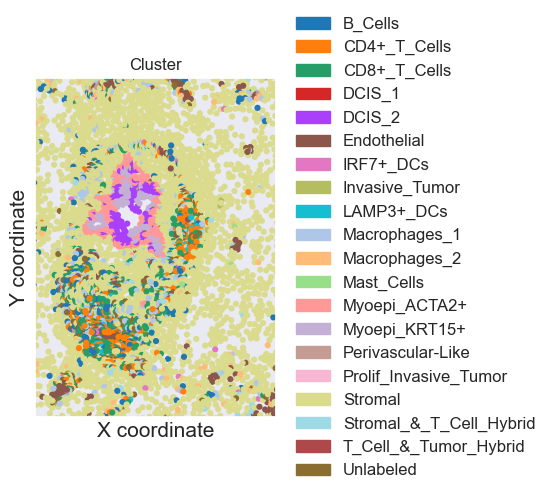

In [16]:
import matplotlib.patches as mpatches

sc.pl.embedding(
    bdata,
    basis="spatial",
    color="Cluster",
    size=80,
    legend_loc="none",
    frameon=True,
    show=False,
)

ax = plt.gca()
ax.set_xlabel("X coordinate", fontsize=15)
ax.set_ylabel("Y coordinate", fontsize=15)
ax.tick_params(axis="both", labelsize=13)
ax.set_xlim(2400, 3400)
ax.set_ylim(2400, 3800)
ax.invert_yaxis()
ax.set_aspect("equal", adjustable="box")

# Retrieve category names and colors stored in adata
cats = bdata.obs["Cluster"].astype("category").cat.categories
colors = bdata.uns.get("Cluster_colors")

handles = [mpatches.Patch(color=c, label=str(cat)) for c, cat in zip(colors, cats)]
ax.legend(handles=handles, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=12)

plt.subplots_adjust(right=0.80)
plt.tight_layout()
plt.show()


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/var/folders/dv/s8n9gshs0qx43w0pr17qhmcm0000h_/T/ipykernel_99391/1044464550.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  bdata_renamed.obs["Cluster"].replace({"DCIS_2": "DCIS"}).astype("category")
/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this 

<Figure size 1000x1000 with 0 Axes>

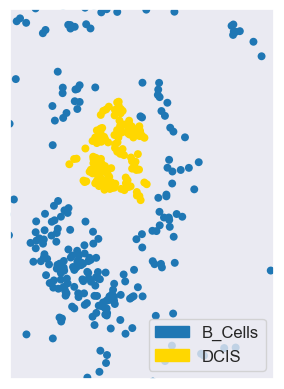

Figure: B_Cells + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

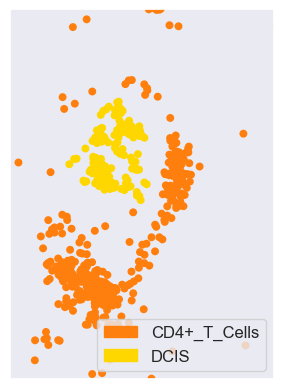

Figure: CD4+_T_Cells + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

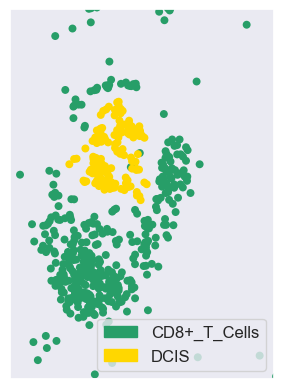

Figure: CD8+_T_Cells + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

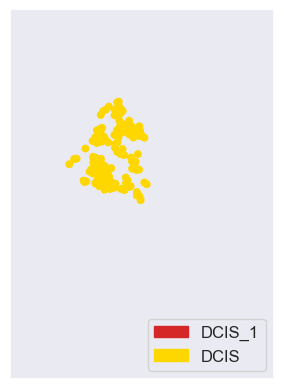

Figure: DCIS_1 + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

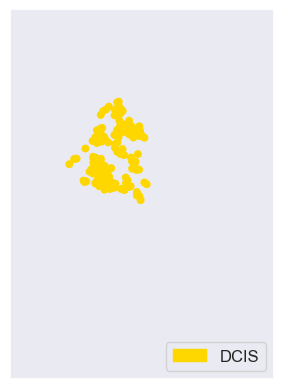

Figure: DCIS + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

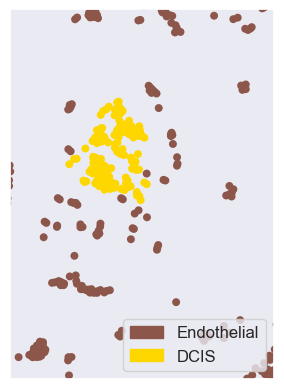

Figure: Endothelial + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

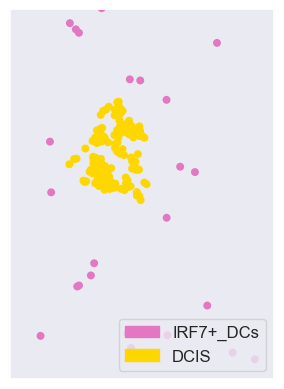

Figure: IRF7+_DCs + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

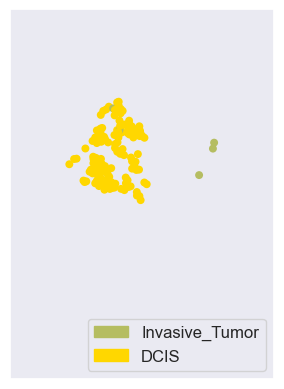

Figure: Invasive_Tumor + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

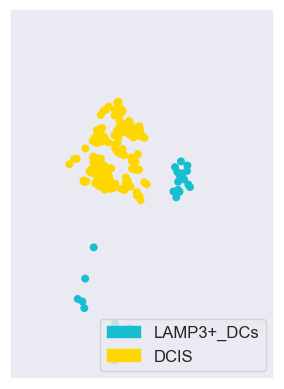

Figure: LAMP3+_DCs + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

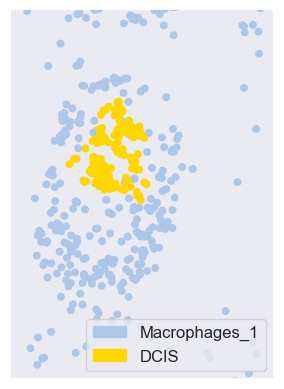

Figure: Macrophages_1 + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

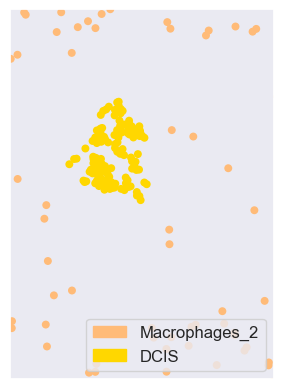

Figure: Macrophages_2 + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

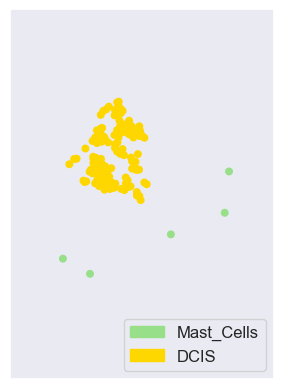

Figure: Mast_Cells + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

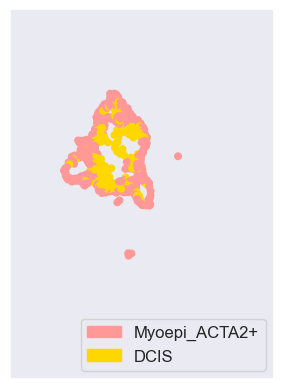

Figure: Myoepi_ACTA2+ + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

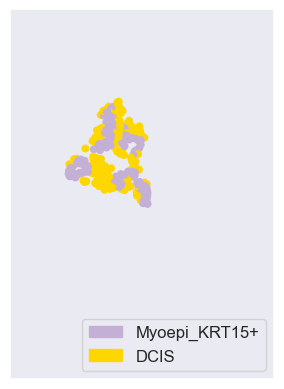

Figure: Myoepi_KRT15+ + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

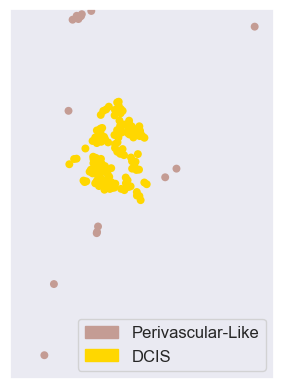

Figure: Perivascular-Like + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

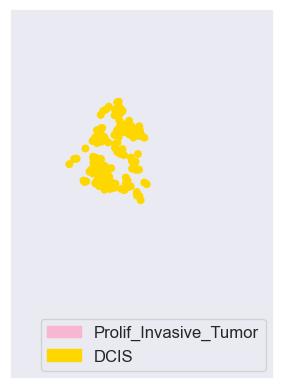

Figure: Prolif_Invasive_Tumor + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

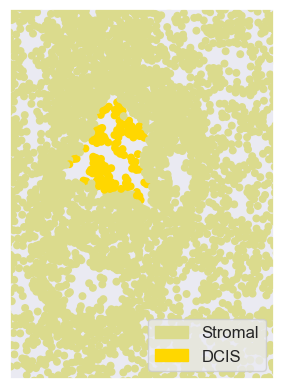

Figure: Stromal + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

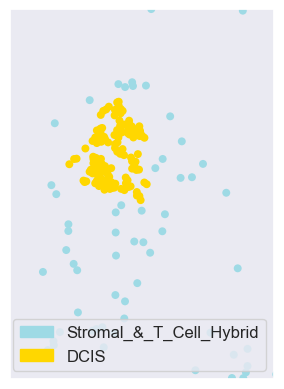

Figure: Stromal_&_T_Cell_Hybrid + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

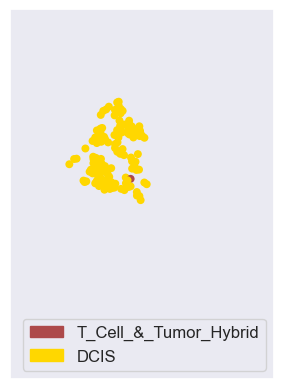

Figure: T_Cell_&_Tumor_Hybrid + DCIS


/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 1000x1000 with 0 Axes>

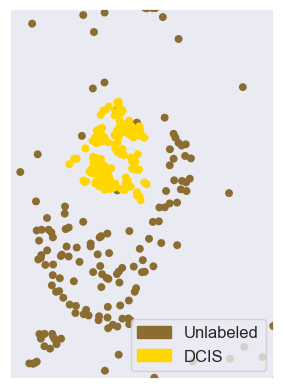

Figure: Unlabeled + DCIS


In [17]:
# List of cluster categories
clusters = bdata.obs["Cluster"].astype("category").cat.categories

# Create a copy of adata and rename DCIS_2 → DCIS
bdata_renamed = bdata.copy()
bdata_renamed.obs["Cluster"] = (
    bdata_renamed.obs["Cluster"].replace({"DCIS_2": "DCIS"}).astype("category")
)

# Color settings: DCIS in yellow, others keep original colors
orig_cats = bdata.obs["Cluster"].astype("category").cat.categories
orig_colors = bdata.uns["Cluster_colors"]
color_dict = dict(zip(orig_cats, orig_colors))

cats = list(bdata_renamed.obs["Cluster"].cat.categories)
colors = []
for c in cats:
    if c == "DCIS":
        colors.append("#FFD700")
    else:
        orig_name = "DCIS_2" if c == "DCIS" and "DCIS_2" in orig_cats else c
        colors.append(color_dict.get(orig_name, "gray"))

bdata_renamed.uns["Cluster_colors"] = colors

# Plot "DCIS + each cluster" separately
for cluster in clusters:
    cluster_name = "DCIS" if cluster == "DCIS_2" else cluster

    plt.figure(figsize=(10, 10))
    sc.pl.spatial(
        bdata_renamed[bdata_renamed.obs["Cluster"].isin([cluster_name, "DCIS"])],
        img_key="hires",
        color="Cluster",
        size=1.5,
        spot_size=20,
        legend_loc="lower right",
        frameon=True,
        show=False,
    )

    ax = plt.gca()

    # Remove axis titles and labels
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="both", labelsize=11)

    # Manually construct legend for selected clusters
    handle_map = {cat: col for cat, col in zip(cats, bdata_renamed.uns["Cluster_colors"])}
    show_labels = [cluster_name, "DCIS"]
    show_labels = list(dict.fromkeys(show_labels))  # Remove duplicates for DCIS plots
    handles = [
        mpatches.Patch(color=handle_map[label], label=label)
        for label in show_labels
    ]
    ax.legend(handles=handles, loc="lower right", frameon=True, fontsize=12)

    ax.set_axis_on()

    # Set ROI limits
    ax.set_xlim(2400, 3400)
    # ax.set_xticks(range(2400, 3401, 200))
    ax.set_ylim(2400, 3800)
    # ax.set_yticks(range(2400, 3801, 200))

    # Align to image coordinate system
    ax.invert_yaxis()
    ax.set_aspect("equal", adjustable="box")

    # Save figure (optional)
    # plt.savefig(f"{root}/cell_location_fig/{cluster_name}_no_tick.png", dpi=300)

    plt.show()
    print(f"Figure: {cluster_name} + DCIS")


In [18]:
from gene_view_tool import plot_gene_polar_hist2d, plot_2d_expression

CD3E: n=3431


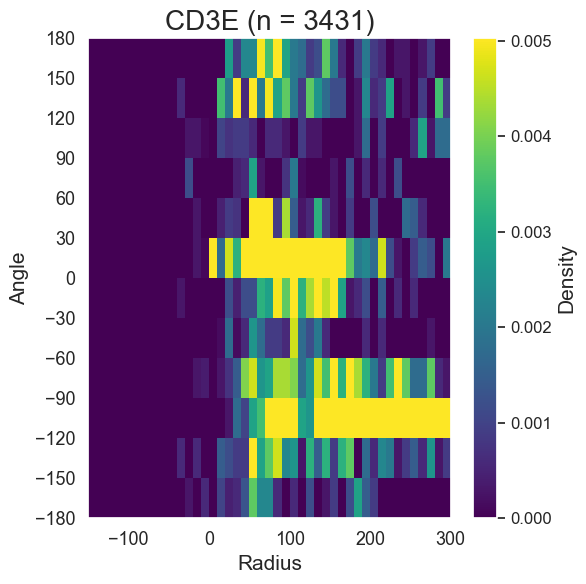

In [19]:
## Draw polar maps
genes = list(subset_grid.var.index)
A_counts, total_n, idx = plot_gene_polar_hist2d(
    subset_grid=subset_grid,
    min_vector_df=min_vector_df,
    gene="CD3E",
)


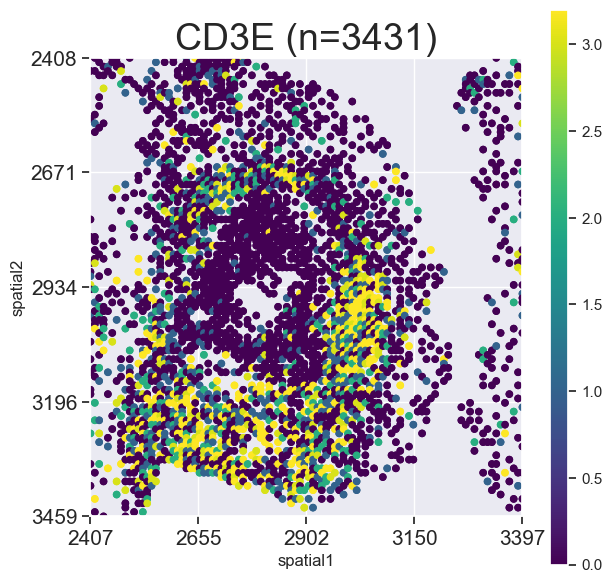

In [20]:
## Draw 2D pictures
g = ["CD3E"] # the genes you want to draw
for g in ["CD3E"]:
    plot_2d_expression(g, subset_grid)

In [21]:
from gene_pipeline import SCOMVPipeline

gene_pipe = SCOMVPipeline(adata=adata, grid=grid, bin_size=10)
gene_out = gene_pipe.run(roi=(2400, 3400, 2400, 3800))

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning: 1 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?/s]

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning: 1 variables were constant, will return nan for these.
  warnings.warn(
/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [22]:
gene_pipe.plot_pcoa_plotly(gene_pipe.coords, gene_pipe.selected_genes)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


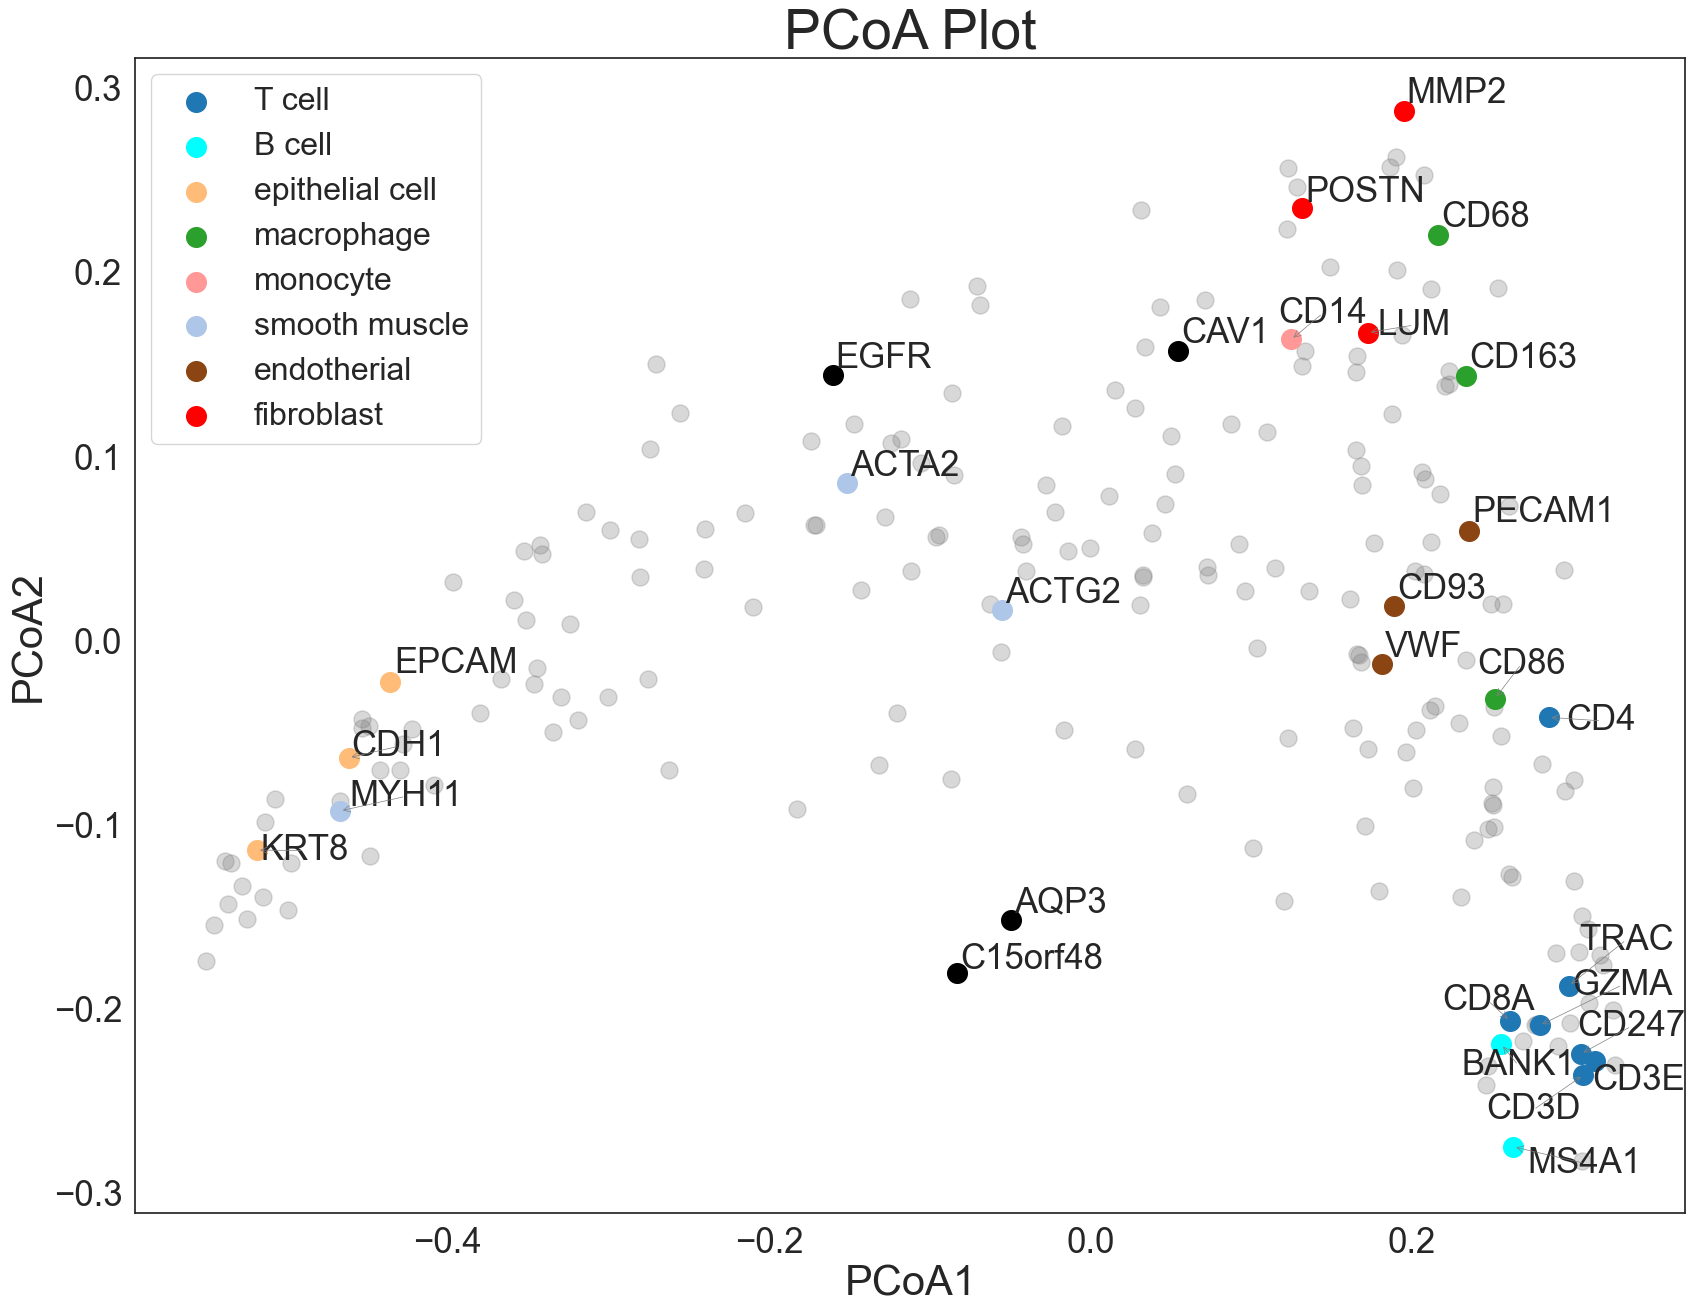

In [23]:
pcoa_two_dims = gene_out["coords"][["PC1", "PC2"]]
df = pcoa_two_dims

# --- Gene sets ---
t_cells  = {"CD3D", "CD3E", "CD4", "CD247", "CD8A", "GZMA", "TRAC"}
micro_f  = ["CD68", "CD80", "CD86", "CD163"]
b_cells  = ["CD19", "BANK1", "MS4A1", "TCL1A", "CD79A"]
mono     = ["CD14"]
epi      = ["CDH1", "EPCAM", "KRT8"]
smooth   = ["ACTA2", "MYH11", "ACTG2"]
endo     = ["CD93", "PECAM1", "VWF"]
fib      = ["POSTN", "LUM", "MMP2"]
focus    = ["PLVAP", "RHOA", "SMAD6", "TP53", "VEGFA", "MKI67", "ADGRL4", "RGS5",
            "PI3", "CAV1", "EGFR", "AQP3", "C15orf48"]

# --- Others (everything except T-cell set) ---
others = sorted(list(set(df.index) - set(t_cells)))

# --- Styling config (keeps your colors/labels/sizes) ---
groups = [
    ("T cell",          t_cells,  "#1f77b4", 200, True),
    ("B cell",          b_cells,  "cyan",    200, True),
    ("epithelial cell", epi,      "#ffbb78", 200, True),
    ("macrophage",      micro_f,  "#2ca02c", 200, True),
    ("monocyte",        mono,     "#ff9896", 200, True),
    ("smooth muscle",   smooth,   "#aec7e8", 200, True),
    ("endotherial",     endo,     "#8B4513", 200, True), 
    ("fibroblast",      fib,      "red",     200, True),
    (None,              focus,    "black",   200, True),  # no legend label
]

# --- Plot ---
plt.figure(figsize=(20, 15))
sns.set_theme(style="white")
texts = []

# Others: gray points (no labels)
for g in others:
    if g in df.index:
        plt.scatter(df.loc[g, "PC1"], df.loc[g, "PC2"], color="gray", alpha=0.3, s=150)

# Highlighted groups
for label, gene_list, color, s, add_text in groups:
    for g in gene_list:
        if g in df.index:
            if label is None:
                plt.scatter(df.loc[g, "PC1"], df.loc[g, "PC2"], color=color, s=s)
            else:
                plt.scatter(df.loc[g, "PC1"], df.loc[g, "PC2"], color=color, label=label, s=s)
            if add_text:
                texts.append(plt.text(df.loc[g, "PC1"], df.loc[g, "PC2"], g, fontsize=25))

plt.xlabel("PCoA1", fontsize=30)
plt.ylabel("PCoA2", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title("PCoA Plot", fontsize=40)

# Legend (remove duplicates)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="best", prop={"size": 23}, ncol=1)

adjust_text(
    texts,
    arrowprops=dict(arrowstyle="->", color="gray", lw=0.5),
    only_move={"points": "xy", "text": "xy"},
    force_text=1.5,
    force_points=1.0,
    expand_text=(1.2, 1.2),
    expand_points=(1.2, 1.2),
    lim=200,
    precision=0.01,
    autoalign="y",
)

plt.show()

In [24]:
from plot_3d import plot_3d

plot_3d(
     adata=gene_out["subset_grid"],
     genes=("POSTN", "CD3E"),
     anchor_gene="CDH1",
     bin_size=10,
     x_range=(2400, 3100),
     y_range=(2400, 3400),
     height_scale=5,
     anchor_scale=1,
     threshold=4,
     sigma=1.0,
 )

In [25]:
from dendrogram import dendrogram2newick
z = linkage(gene_out["dist_df"], metric='euclidean', method='ward')
tree= to_tree(z)
newick = dendrogram2newick(tree, tree.dist, gene_out["selected_genes"])

/var/folders/dv/s8n9gshs0qx43w0pr17qhmcm0000h_/T/ipykernel_99391/272915593.py:2: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [26]:
#newick

In [27]:
from gene import run_full_pipeline

roi_list = [
    (4800, 5900, 950, 1900),
    (6920, 7570, 1910, 2390),
    (5300, 6400, 3050, 3900),
    (6050, 7050, 3910, 5100),
    (3900, 4500, 4600, 5200),
    (2400, 3400, 2400, 3800),
    (2700, 4000, 750, 1690),
    (1000, 2100, 1700, 2500),
    (400, 1500, 3600, 4200),
    (900, 1700, 4200, 5300),
    
]

In [28]:
results = []
dfs = []

for roi in tqdm(roi_list, desc="Running ROI pipelines"):
    res = run_full_pipeline(
        adata=adata,
        grid=grid,
        roi=roi,
        min_gene_percentile=30,
        max_gene_percentile=95,
        require_moran_nonneg=True,
    )
    results.append(res)
    dfs.append(res["dist_df"])


Running ROI pipelines:   0%|                             | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?/s]

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
Running ROI pipelines:  10%|██                   | 1/10 [00:16<02:31, 16.88s/it]/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning:

1 variables were constant, will return nan for these.



  0%|          | 0/100 [00:00<?, ?/s]

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
Running ROI pipelines:  20%|████▏                | 2/10 [00:32<02:09, 16.17s/it]/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning:

1 variables were constant, will return nan for these.



  0%|          | 0/100 [00:00<?, ?/s]

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
Running ROI pipelines:  30%|██████▎              | 3/10 [00:54<02:10, 18.60s/it]

  0%|          | 0/100 [00:00<?, ?/s]

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
Running ROI pipelines:  40%|████████▍            | 4/10 [01:14<01:56, 19.42s/it]/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning:

4 variables were constant, will return nan for these.



  0%|          | 0/100 [00:00<?, ?/s]

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
Running ROI pipelines:  50%|██████████▌          | 5/10 [01:28<01:26, 17.36s/it]/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning:

1 variables were constant, will return nan for these.



  0%|          | 0/100 [00:00<?, ?/s]

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
Running ROI pipelines:  60%|████████████▌        | 6/10 [01:46<01:10, 17.55s/it]

  0%|          | 0/100 [00:00<?, ?/s]

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
Running ROI pipelines:  70%|██████████████▋      | 7/10 [02:09<00:57, 19.25s/it]/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning:

1 variables were constant, will return nan for these.



  0%|          | 0/100 [00:00<?, ?/s]

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
Running ROI pipelines:  80%|████████████████▊    | 8/10 [02:29<00:39, 19.75s/it]

  0%|          | 0/100 [00:00<?, ?/s]

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
Running ROI pipelines:  90%|██████████████████▉  | 9/10 [02:47<00:18, 18.98s/it]

  0%|          | 0/100 [00:00<?, ?/s]

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
Running ROI pipelines: 100%|████████████████████| 10/10 [03:05<00:00, 18.50s/it]


In [29]:
common_genes = set.intersection(*[set(df.index) for df in dfs])

print(f"the number of common genes: {len(common_genes)}")

for i in range(len(dfs)):
    dfs[i] = dfs[i].loc[sorted(common_genes), sorted(common_genes)]


the number of common genes: 157


In [30]:
from sklearn.decomposition import NMF
from nmf import SymNMF

n_components = 1

W_results = {}
H_results = {}

    
rng = np.random.default_rng(123)

for i, df in enumerate(dfs):
    min_x, max_x, min_y, max_y  = roi_list[i]

    key = f"{min_x}<x<{max_x}, {min_y}<y<{max_y}"
    A = df.to_numpy()
    sigma = np.abs(rng.normal(scale=0.1, size=A.size)).reshape(A.shape)
    A = A + (sigma + sigma.T)/2

    snmf = SymNMF(k=1, random_state=123)
    snmf.fit(A)

    H_results[key] = snmf.H




In [31]:
feature_matrix = []
keys = []

for key, H in H_results.items():
    mean_vec = H.mean(axis=1)
    feature_matrix.append(mean_vec)
    keys.append(key)

feature_matrix = np.array(feature_matrix)

In [32]:
from sklearn.cluster import KMeans

n_clusters = 3  # define the number of cluster
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(feature_matrix)

print("the result of clustering:", clusters)


the result of clustering: [2 2 2 2 0 0 1 1 1 1]


In [35]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from adjustText import adjust_text

annotation_dist = {}
annotation_dist["4800<x<5900, 950<y<1900"]= "1 (DCIS)"
annotation_dist["6920<x<7570, 1910<y<2390"]= "2 (DCIS)"
annotation_dist["5300<x<6400, 3050<y<3900"]= "3 (DCIS)"
annotation_dist["6050<x<7050, 3910<y<5100"]= "4 (DCIS)"
annotation_dist["3900<x<4500, 4600<y<5200"]= "5 (DCIS)"
annotation_dist["2400<x<3400, 2400<y<3800"]= "6 (DCIS)"

annotation_dist["2700<x<4000, 750<y<1690"]= "7 (IDC)"
annotation_dist["1000<x<2100, 1700<y<2500"]= "8 (IDC)"
annotation_dist["400<x<1500, 3600<y<4200"]= "9 (IDC)"
annotation_dist["900<x<1700, 4200<y<5300"]= "10 (IDC)"


# ======== Prepare data for clustering ========
feature_matrix = []
keys = []

for key, H in H_results.items():
    # H: shape = (n_components, n_samples)
    mean_vec = H.mean(axis=1)
    feature_matrix.append(mean_vec)
    keys.append(key)

feature_matrix = np.array(feature_matrix)

# ======== KMeans clustering ========
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(feature_matrix)
print("Clustering results (groups of 10 datasets):", clusters)

# ======== Hierarchical clustering ========
labels = [f"ROI{annotation_dist[key]}" for key in keys]
Z = linkage(feature_matrix, method="average")


Clustering results (groups of 10 datasets): [2 2 2 2 0 0 1 1 1 1]


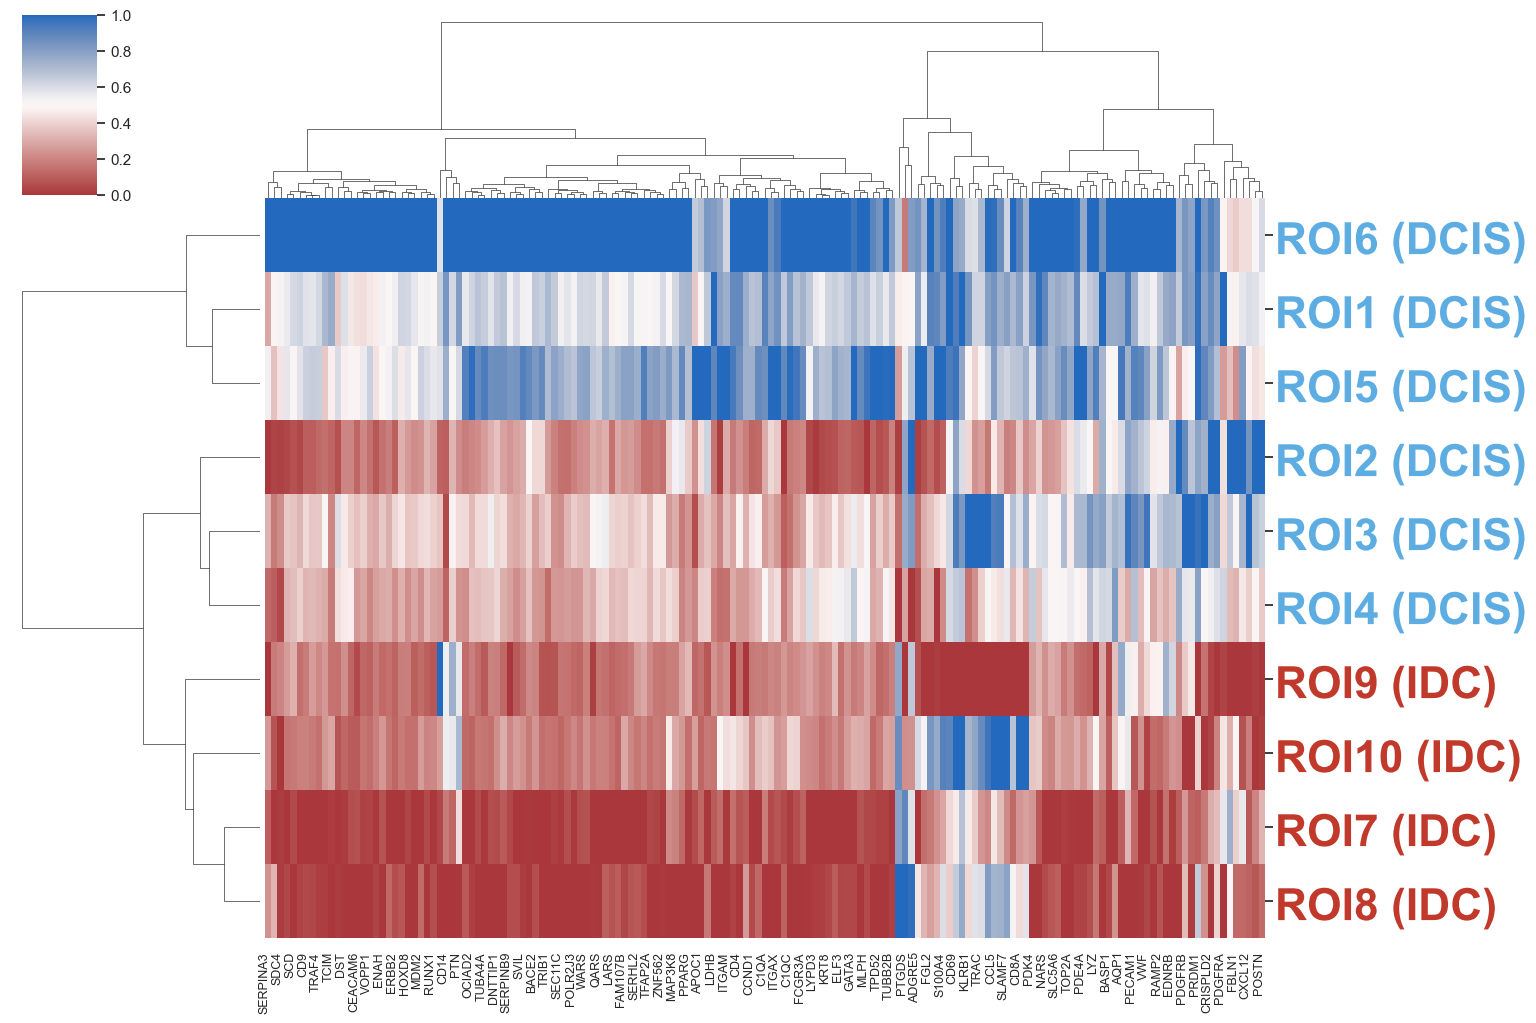

In [36]:
import matplotlib.patheffects as pe

df_features = pd.DataFrame(feature_matrix, index=keys)
labels = [f"ROI{annotation_dist[key]}" for key in keys]
new_dict = {i: g for i, g in enumerate(sorted(common_genes))}

cg = sns.clustermap(
    df_features,
    method='ward',
    metric='euclidean',
    cmap='vlag_r',
    standard_scale=1,
    figsize=(15, 10),
    dendrogram_ratio=(0.2, 0.2),
    cbar_pos=(0.02, 0.8, 0.05, 0.18)
)

new_order = cg.dendrogram_row.reordered_ind
ax = cg.ax_heatmap

# ---------- Prepare row labels ----------
yticklabels = [labels[i] for i in new_order]

# Remove original y-axis tick labels
ax.set_yticklabels([])

# Get current y-tick positions (row centers)
yticks = ax.get_yticks()

# Define vertical offset for label positioning
# Positive values shift labels downward
dy = +0.1  # Try values such as -0.1, -0.2, -0.5 if needed

for y, lab in zip(yticks, yticklabels):

    # ---- Color labels by DCIS / IDC ----
    if "DCIS" in lab:
        color = "#5DADE2"
    elif "IDC" in lab:
        color = "#C0392B"
    else:
        color = "black"

    ax.text(
        1.01,
        y + dy,
        lab,
        transform=ax.get_yaxis_transform(),  # x in axes coordinates, y in data coordinates
        ha='left',
        va='center',
        fontsize=32,
        fontweight='bold',
        color=color,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")],
    )

# ---------- Column labels (same as before) ----------
new_order_col = cg.dendrogram_col.reordered_ind
xticklabels = [new_dict[i] for i in new_order_col]
xticklabels_sparse = [
    label if (idx % 2 == 0) else ''
    for idx, label in enumerate(xticklabels)
]

ax.set_xticks(range(len(xticklabels_sparse)))
ax.set_xticklabels(xticklabels_sparse, rotation=90, fontsize=9)

# plt.savefig("heatmap_20251117.png", dpi=300, bbox_inches='tight')
plt.show()


In [37]:
from spatial_deg import Spatial_DEG

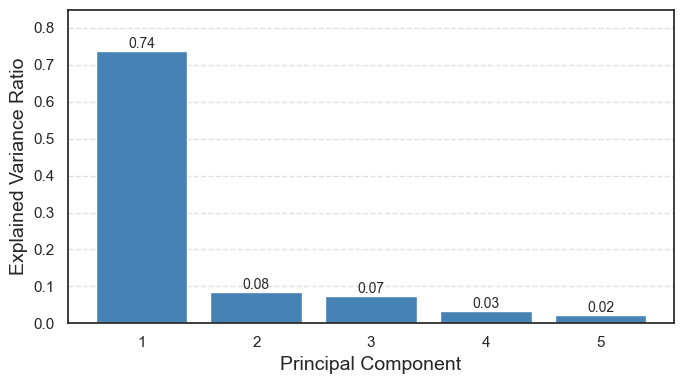

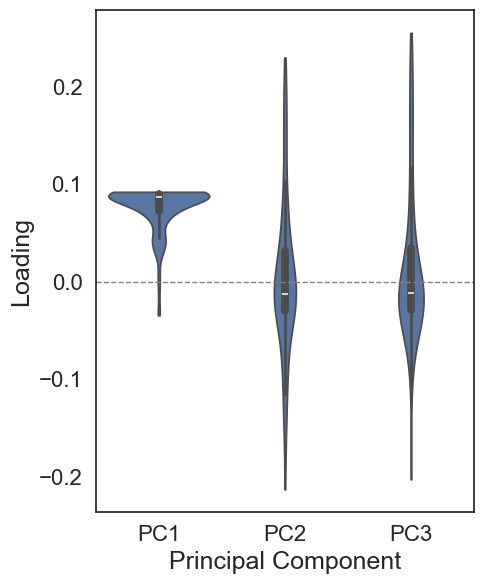

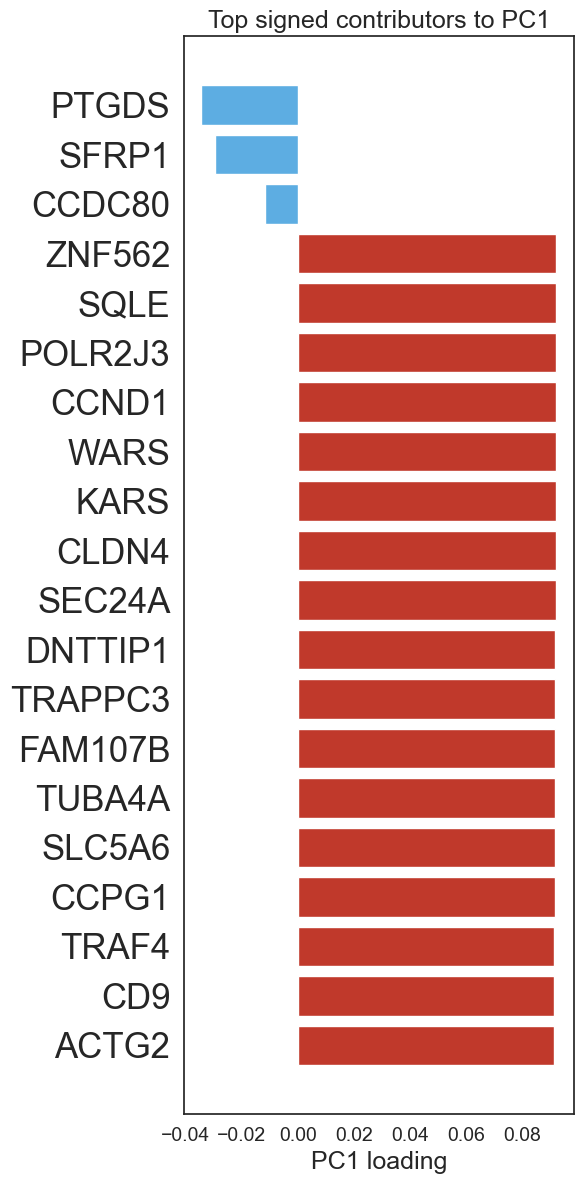

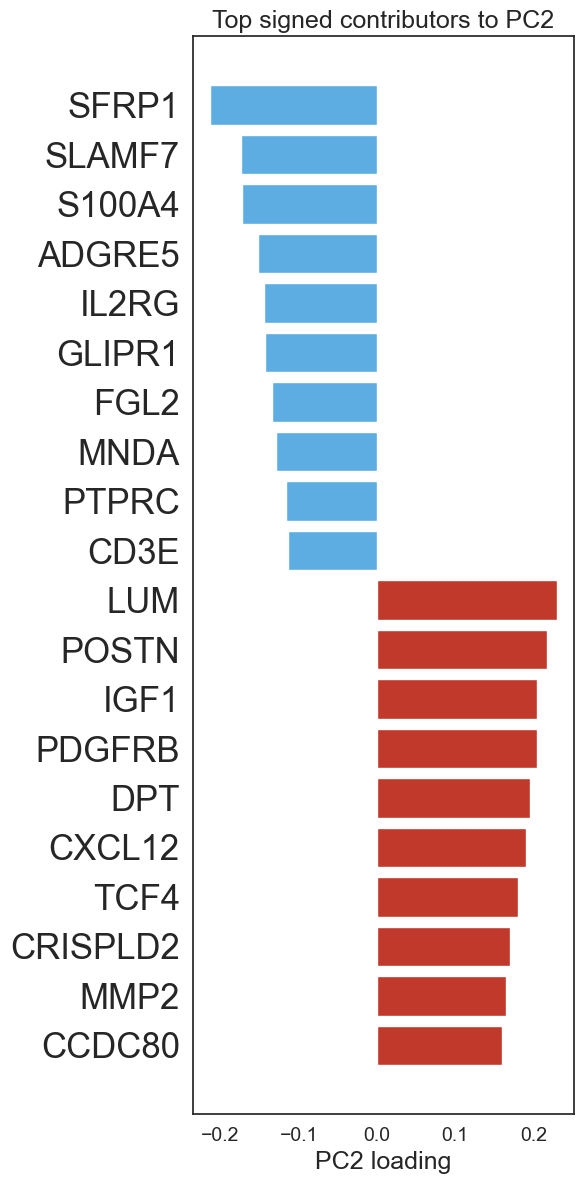

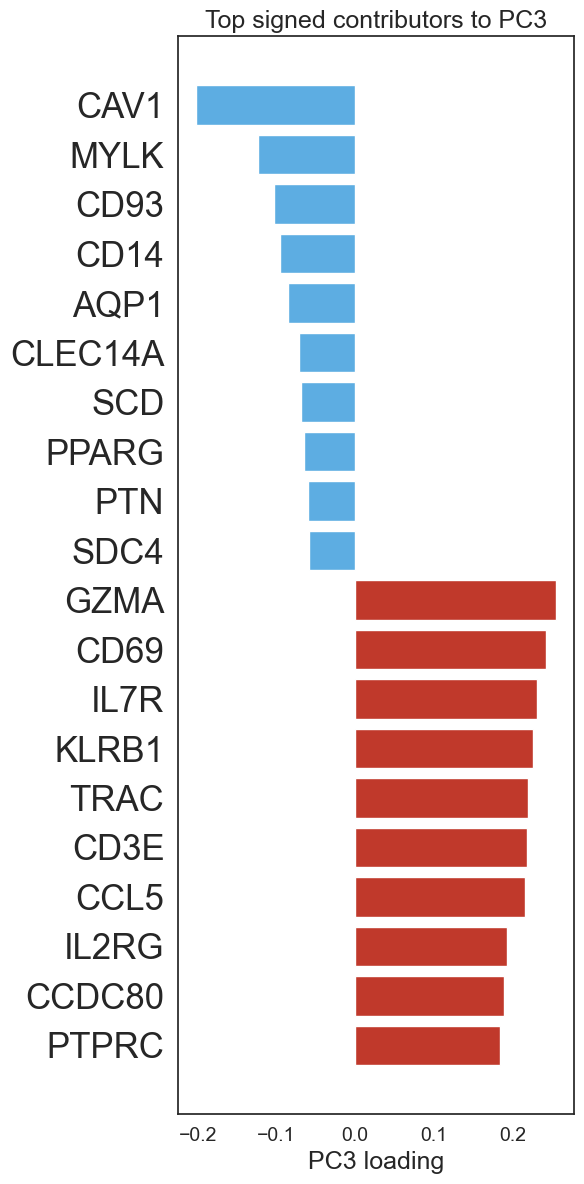

In [38]:
report = Spatial_DEG(n_components=5, standardize=True).fit(
    feature_matrix,
    feature_names=list(new_dict.values())
)

sns.set_theme(style="white")

# 1) Cumulative explained variance
report.plot_explained_variance_bar(max_pc=10)

# 2) Violin plots of loadings (PC1–PC3)
report.plot_loading_violin(pcs=(0, 1, 2))

# 3) Signed top contributing genes for PC1, PC2, and PC3 (bar plots)
report.plot_signed_top_contributions_multi(pcs=(0, 1, 2), top_pos=10, top_neg=10)

# Retrieve top positively and negatively contributing genes
top_df = report.get_top_genes_signed(pcs=(0, 1, 2), top_pos=10, top_neg=10)

# Extract unique genes from the top contributors
top_pca_genes = top_df["gene"].drop_duplicates().tolist()

# Exclude PC1 and keep genes ranked within top 5
top_df = top_df[(top_df["PC"] != "PC1") & (top_df["rank"] <= 5)]

# Final list of top PCA-associated genes
top_pca_genes = top_df["gene"].drop_duplicates().tolist()


In [39]:
report = Spatial_DEG(n_components=3, standardize=True).fit(
    feature_matrix,
    feature_names=common_genes
)

# 1) conduct UMAP
umap_df = report.fit_umap_on_loadings(
    n_neighbors=5,
    min_dist=0.1,
    random_state=57,
)

# 2) show 2D maps
report.plot_umap_loadings_interactive(umap_df)


2025-12-26 00:20:59.030497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



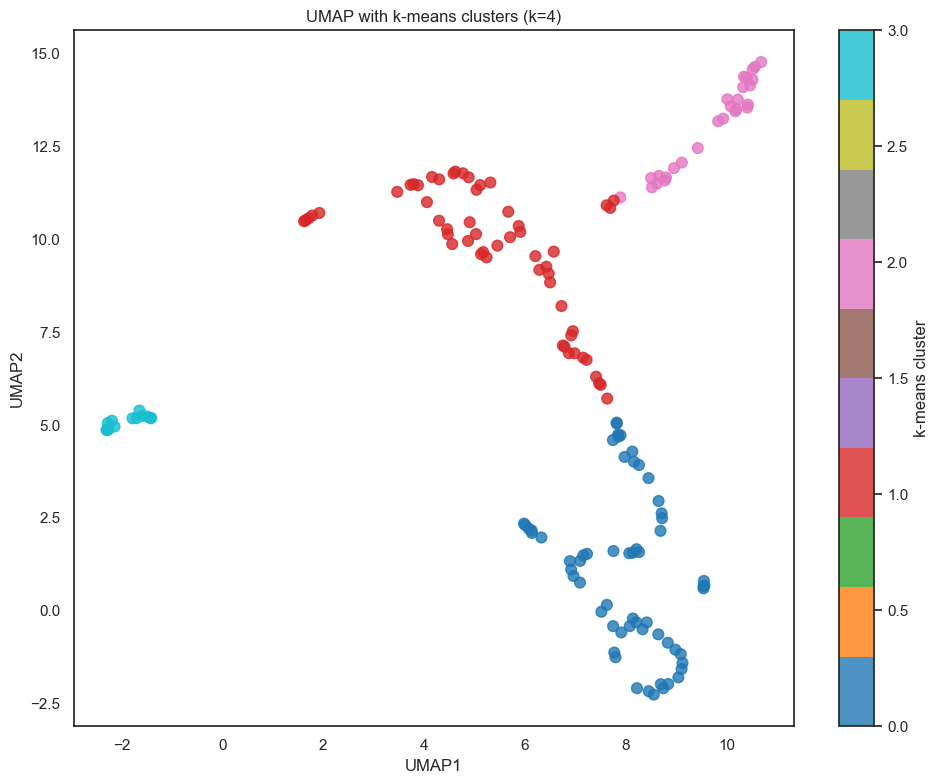

In [40]:
# Extract UMAP coordinates
X = umap_df[["UMAP1", "UMAP2"]].values

# k-means（4クラスタ）
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Add the results to the DataFrame
umap_df["kmeans_cluster"] = cluster_labels

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    umap_df["UMAP1"],
    umap_df["UMAP2"],
    c=umap_df["kmeans_cluster"],
    cmap="tab10",
    s=60,
    alpha=0.8
)
plt.colorbar(scatter, label="k-means cluster")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP with k-means clusters (k=4)")
plt.tight_layout()
plt.show()


In [41]:
# Load the file containing spatial distribution annotations
annotation_path = "./dataset/breast_gene_annotate.csv"
annotate_df = pd.read_csv(annotation_path)

## Label PCoA components
def add_info(clu_num, names, gene_name, doubt_info , selected_genes):
    if gene_name in selected_genes:
    #if gene_name in selected_genes:
        # Convert labels from 1–6 to 0-based indexing by subtracting 1
        index_ = int(clu_num) - 1
        names[index_].append(gene_name)


names = [[] for i in range(6)]
for i in range(annotate_df.shape[0]):
    clu_num = annotate_df.iloc[i, 1]
    if not clu_num ==  'NaN':
        gene_name = annotate_df.iloc[i, 0]
        doubt_info = annotate_df.iloc[i, 2]
        add_info(clu_num, names, gene_name, doubt_info, gene_pipe.selected_genes)

pheris = names[0]
print(f"pheri: {len(pheris)}")
insides = names[1]
print(f"inside: {len(insides)}")
lows = names[2]
print(f"low: {len(lows)}")
ubi_in = names[3]
print(f"ubi_in: {len(ubi_in)}")
ubi_out = names[4]
print(f"ubi_out: {len(ubi_out)}")

label_df = annotate_df.iloc[:, :2]
label_df.columns = ["label", "gene"]

for index_name in umap_df.index:
    if index_name in names[0]:
        umap_df.loc[index_name, 'annotation'] = "peripheral"
    elif index_name in names[1]:
        umap_df.loc[index_name, 'annotation'] = "internal"
    elif index_name in names[2]:
        umap_df.loc[index_name, 'annotation'] = "low"
    elif index_name in names[3]:
        umap_df.loc[index_name, 'annotation'] = "ubiquitous (include internal)"
    elif index_name in names[4]:
        umap_df.loc[index_name, 'annotation'] = "ubiquitous (not include internal)"


pheri: 91
inside: 52
low: 0
ubi_in: 49
ubi_out: 27


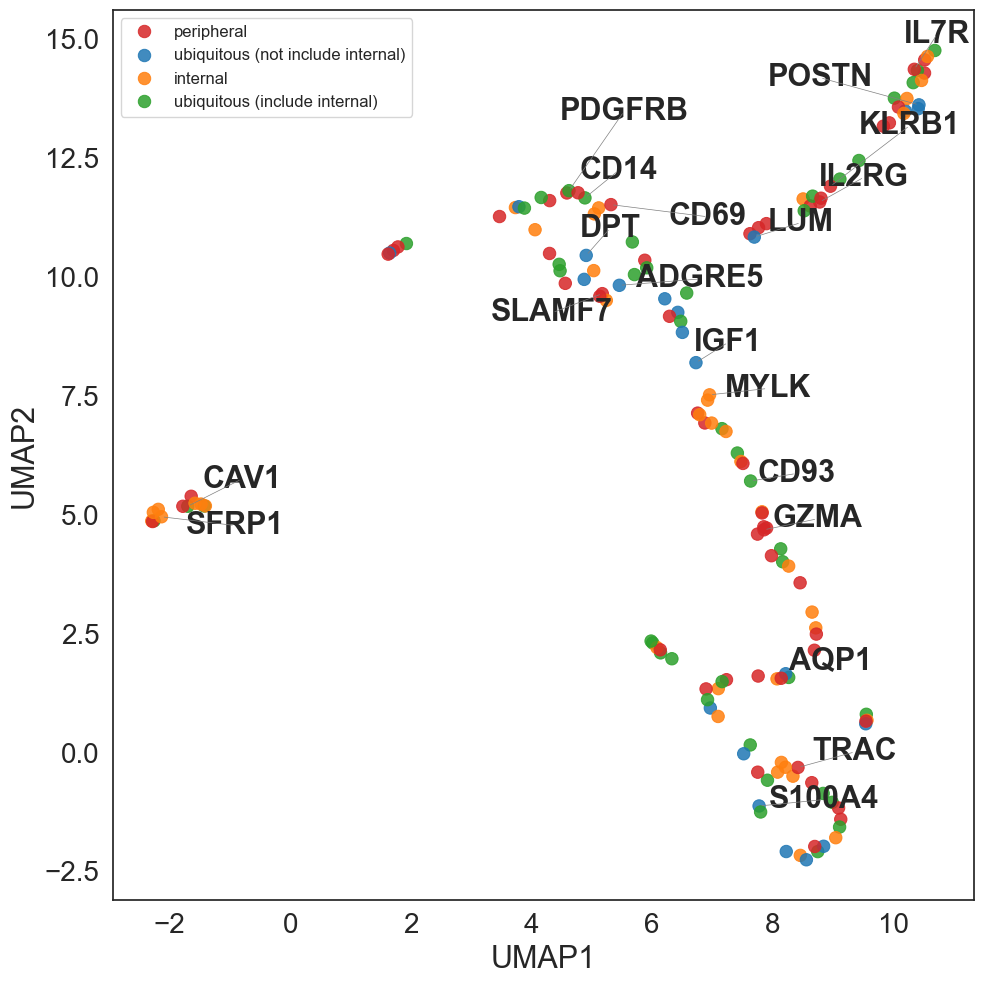

In [42]:
plt.figure(figsize=(10, 10), facecolor="white")

palette = {
    "peripheral": "tab:red",
    "internal": "tab:orange",
    "ubiquitous (include internal)": "tab:green",
    "ubiquitous (not include internal)": "tab:blue"
}

# --- Scatter plot colored by annotation ---
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="annotation",
    palette=palette,
    s=80,
    alpha=0.85,
    edgecolor=None,
)

texts = []
for gene, row in umap_df.iterrows():
    if gene in top_pca_genes:
        texts.append(
            plt.text(
                row["UMAP1"],
                row["UMAP2"],
                gene,
                fontsize=22,
                fontweight="bold"
            )
        )

# --- Avoid label overlap using adjustText ---
adjust_text(
    texts,
    only_move={'points': 'y', 'text': 'xy'},
    force_text=1.5,
    force_points=1.0,
    expand_text=(1.2, 1.3),
    expand_points=(1.2, 1.3),
    arrowprops=dict(arrowstyle="-", lw=0.5, color="gray")
)

# Axes and labels
plt.xlabel("UMAP1", fontsize=22)
plt.xticks(fontsize=20)
plt.ylabel("UMAP2", fontsize=22)
plt.yticks(fontsize=20)
# plt.title("UMAP Gene Embedding Colored by Annotation", fontsize=20)

plt.legend(fontsize=12, loc="best")
plt.tight_layout()
# plt.show()


In [43]:
top_df = top_df[(top_df["PC"] != "PC1") & (top_df["rank"] <= 5)]
top_pca_genes = top_df["gene"].drop_duplicates().tolist()

In [44]:
# DEG analysis
import scanpy as sc

region1 = (grid.obs["imagecol"].between(4800, 5900)) & (grid.obs["imagerow"].between(950, 1900))
region2 = (grid.obs["imagecol"].between(6920, 7570)) & (grid.obs["imagerow"].between(1910, 2390))
region3 = (grid.obs["imagecol"].between(5300, 6400)) & (grid.obs["imagerow"].between(3050, 3900))
region4 = (grid.obs["imagecol"].between(6050, 7050)) & (grid.obs["imagerow"].between(3910, 5100))
region5 = (grid.obs["imagecol"].between(3900, 4500)) & (grid.obs["imagerow"].between(4600, 5200))
region6 = (grid.obs["imagecol"].between(2400, 3400)) & (grid.obs["imagerow"].between(2400, 3800))

region7 = (grid.obs["imagecol"].between(2700, 4000)) & (grid.obs["imagerow"].between(750, 1690))
region8 = (grid.obs["imagecol"].between(1000, 2100)) & (grid.obs["imagerow"].between(750, 1690))
region9 = (grid.obs["imagecol"].between(400, 1500)) & (grid.obs["imagerow"].between(3600, 4200))
region10 = (grid.obs["imagecol"].between(900, 1700)) & (grid.obs["imagerow"].between(3600, 4200))


grid.obs["deg_group"] = None

# Labeling
grid.obs.loc[region1, "deg_group"] = 1
grid.obs.loc[region2, "deg_group"] = 2
grid.obs.loc[region3, "deg_group"] = 3
grid.obs.loc[region4, "deg_group"] = 4
grid.obs.loc[region5, "deg_group"] = 5
grid.obs.loc[region6, "deg_group"] = 6

grid.obs.loc[region7, "deg_group"] = 7
grid.obs.loc[region8, "deg_group"] = 8
grid.obs.loc[region9, "deg_group"] = 9
grid.obs.loc[region10, "deg_group"] = 10

grid.obs["deg_group_merged"] = grid.obs["deg_group"].map({
    1: "A",
    2: "A",
    3: "A",
    4: "A",
    5: "A",
    6: "A",
    
    7: "B",  
    8: "B",
    9: "B",
    10: "B",
})


# Extract only valid cells
grid_deg = grid[grid.obs["deg_group_merged"].notna()].copy()


sc.tl.rank_genes_groups(
    grid_deg,
    groupby="deg_group_merged",
    groups=["B"],
    reference="A",
    method="wilcoxon"
)

deg_df = sc.get.rank_genes_groups_df(grid_deg, group="B")

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



In [45]:
adata_sub = grid_deg
use_genes = ['PELI1', 'FOXA1', 'APOC1', 'NARS', 'CXCL12', 'HOOK2', 'ANKRD30A', 'CCND1', 'TCF4', 'OCIAD2', 'SCD', 'CD69', 'TRAC', 'LYPD3', 'AQP1', 'KARS', 'LUM', 'RAB30', 'TACSTD2', 'SH3YL1', 'IGF1', 'GLIPR1', 'EGFR', 'PDGFRB', 'ACTA2', 'KRT7', 'FAM107B', 'CD3E', 'CYTIP', 'POLR2J3', 'BACE2', 'PDK4', 'FBLN1', 'DSP', 'ENAH', 'VOPP1', 'SVIL', 'KLRB1', 'FSTL3', 'TRIB1', 'KRT8', 'CLDN4', 'ADGRE5', 'AKR1C1', 'EPCAM', 'HDC', 'PPARG', 'TRAPPC3', 'DUSP5', 'CCL5', 'CXCR4', 'IL7R', 'SERHL2', 'LYZ', 'TFAP2A', 'AIF1', 'FASN', 'ANKRD28', 'ITM2C', 'LDHB', 'ZEB2', 'C1QA', 'CD4', 'SEC24A', 'FCER1G', 'ERN1', 'SLAMF7', 'CTTN', 'MRC1', 'CCPG1', 'MLPH', 'RUNX1', 'ZNF562', 'CLEC14A', 'SMS', 'CEACAM6', 'ACTG2', 'PECAM1', 'PIM1', 'CCDC6', 'MMP2', 'DSC2', 'HAVCR2', 'TCIM', 'ITGAM', 'CD68', 'PTGDS', 'QARS', 'MYO5B', 'SDC4', 'IL2RG', 'PTPRC', 'WARS', 'MNDA', 'FLNB', 'ZEB1', 'DST', 'FGL2', 'PCLAF', 'AR', 'S100A14', 'TENT5C', 'LARS', 'BASP1', 'CD8A', 'FBLIM1', 'S100A4', 'HMGA1', 'JUP', 'ITGAX', 'CD3G', 'ERBB2', 'SEC11C', 'PTN', 'PRDM1', 'GPR183', 'MDM2', 'ELF3', 'EDNRB', 'CAV1', 'SERPINB9', 'DNTTIP1', 'MAP3K8', 'SLC5A6', 'CD9', 'CCDC80', 'SQLE', 'GATA3', 'BTNL9', 'PDE4A', 'SFRP1', 'RAMP2', 'PDGFRA', 'MYLK', 'CD14', 'IGSF6', 'VWF', 'CD93', 'DPT', 'POSTN', 'ADAM9', 'TOP2A', 'TPD52', 'HOXD8', 'CD247', 'SFRP4', 'SERPINA3', 'CD163', 'TRAF4', 'FCGR3A', 'KLF5', 'GZMA', 'C1QC', 'LPXN', 'CDH1', 'CRISPLD2', 'TOMM7', 'TUBA4A']

/Users/nomuraryosuke/miniconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/get/get.py:69: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



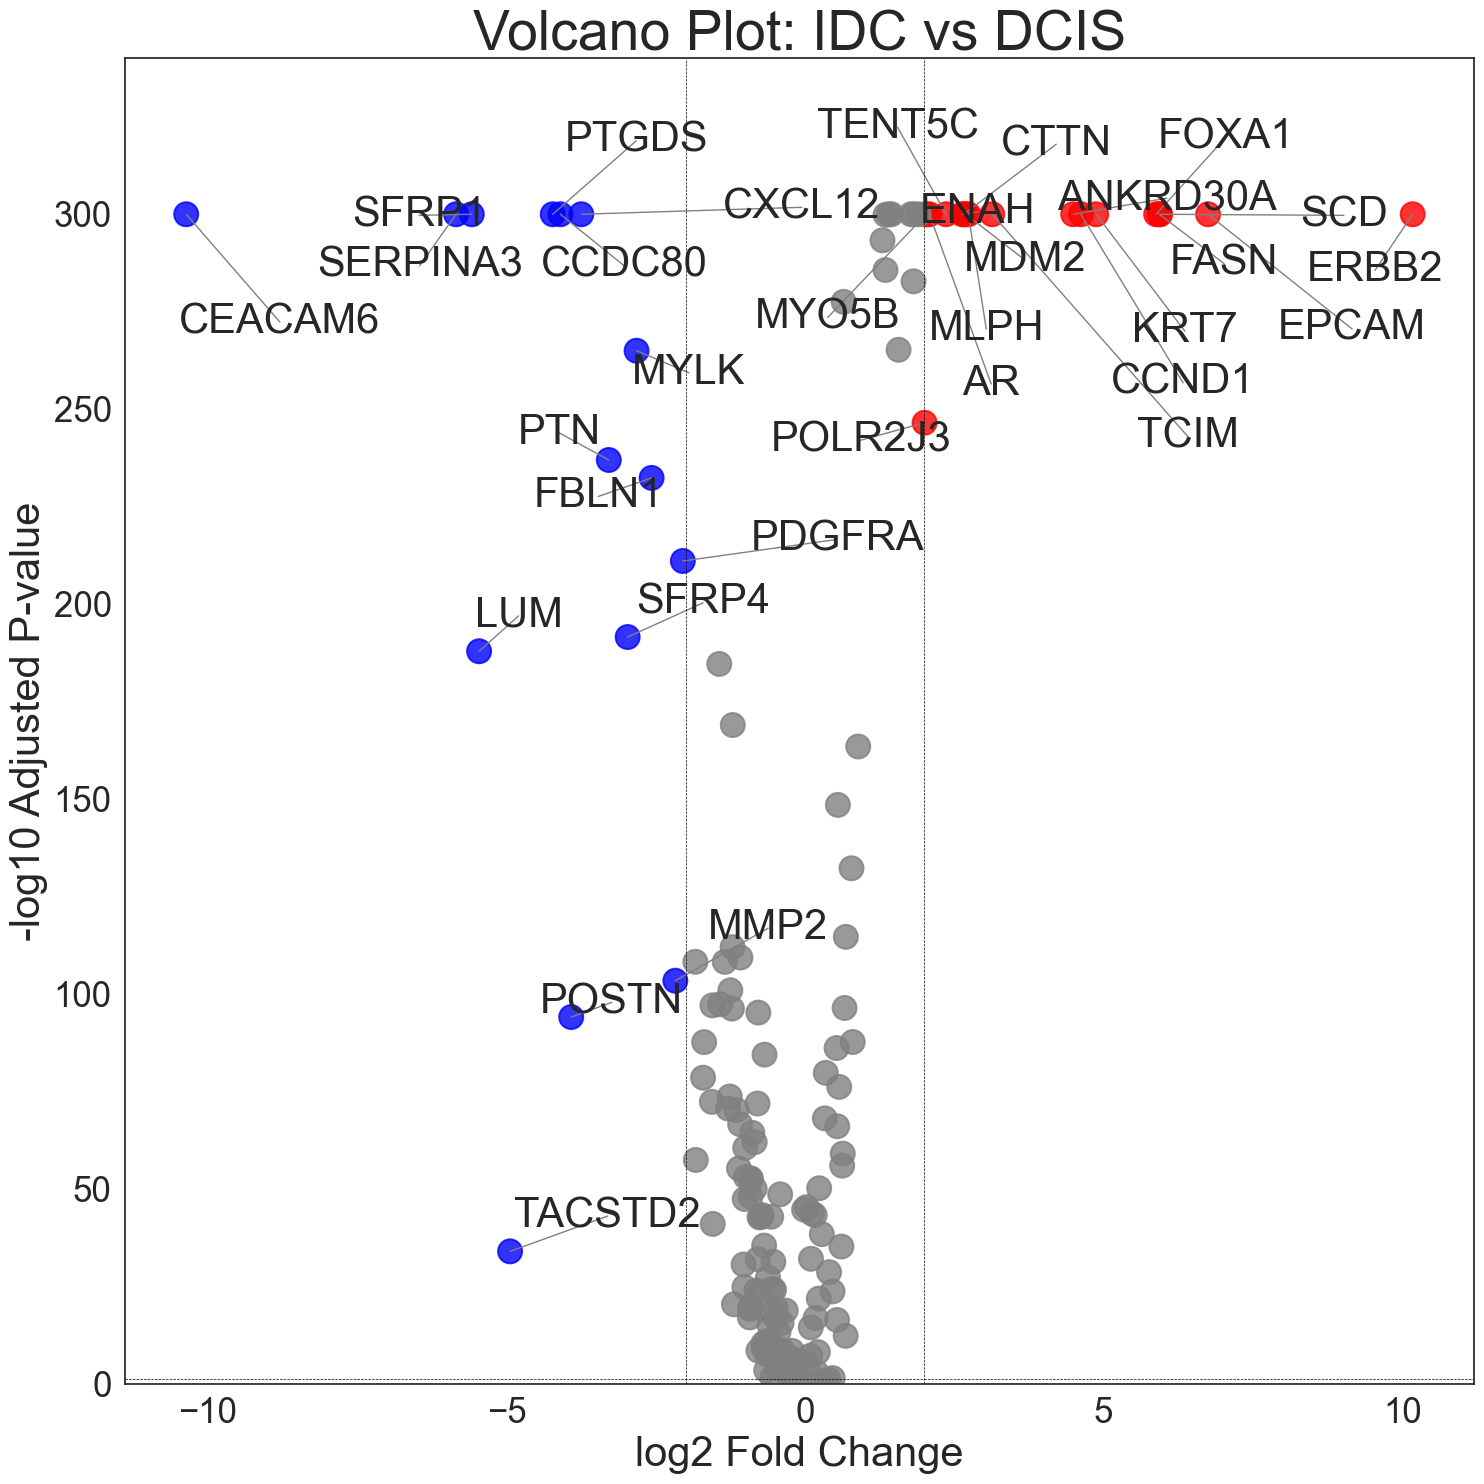

In [46]:
# ===========================================
# 0. Extract DE results and subset
# ===========================================
deg_df = sc.get.rank_genes_groups_df(adata_sub, group="B")
deg_df = deg_df[deg_df["names"].isin(use_genes)].copy()
deg = deg_df.copy()

# ===========================================
# 1. logFC and -log10(pval) (handle p=0)
# ===========================================
deg["logFC"] = deg["logfoldchanges"]

eps = 1e-300
deg["pvals_adj_clipped"] = deg["pvals_adj"].clip(lower=eps)
deg["-log10(pval)"] = -np.log10(deg["pvals_adj_clipped"])

# ===========================================
# 2. Color labels: up / down / ns
# ===========================================
def classify_gene(row):
    if row["pvals_adj"] < 0.05 and row["logFC"] > 2:
        return "up"
    elif row["pvals_adj"] < 0.05 and row["logFC"] < -2:
        return "down"
    else:
        return "ns"

deg["color"] = deg.apply(classify_gene, axis=1)
color_map = {"up": "red", "down": "blue", "ns": "gray"}

# ===========================================
# 3. Genes to label
# ===========================================
label_df = deg[
    (deg["color"].isin(["up", "down"])) &
    (deg["-log10(pval)"] >= 10)
]

force_labels = ["SFRP1"]
force_df = deg[deg["names"].isin(force_labels)]

high_thr = label_df["-log10(pval)"].quantile(0.8)

# ===========================================
# 4. Main plot
# ===========================================
fig, ax = plt.subplots(figsize=(15, 15))

sns.scatterplot(
    data=deg,
    x="logFC",
    y="-log10(pval)",
    hue="color",
    palette=color_map,
    edgecolor=None,
    s=300,
    alpha=0.8,
    legend=False,
    ax=ax
)

# ===========================================
# 5. Place labels (store texts and original point coordinates)
# ===========================================
texts = []
anchors_x = []   # point x coordinates (logFC)
anchors_y = []   # point y coordinates (-log10p)

# 5-1. Regular labels
for _, row in label_df.iterrows():
    gene = row["names"]
    x0 = row["logFC"]
    y0 = row["-log10(pval)"]

    # Initial label position
    x = x0
    y = y0 + 2
    if y0 >= high_thr:
        y = y0 - 20

    t = ax.text(
        x, y, gene,
        fontsize=30,
        ha='center',
        va='bottom'
    )
    texts.append(t)
    anchors_x.append(x0)
    anchors_y.append(y0)

# 5-2. Forced labels
already = set(label_df["names"])
for _, row in force_df.iterrows():
    gene = row["names"]
    if gene in already:
        continue

    x0 = row["logFC"]
    y0 = row["-log10(pval)"]

    x = x0
    y = y0 + 2
    if y0 >= high_thr:
        y = y0 - 20

    t = ax.text(
        x, y, gene,
        fontsize=30,
        ha='center',
        va='bottom',
        color="black"
    )
    texts.append(t)
    anchors_x.append(x0)
    anchors_y.append(y0)

# ===========================================
# 6. Set axis limits (roughly)
# ===========================================
xmin = deg["logFC"].min()
xmax = deg["logFC"].max()
dx = (xmax - xmin) * 0.05 if xmax > xmin else 1.0
ax.set_xlim(xmin - dx, xmax + dx)

ymax_data = deg["-log10(pval)"].max()
ymax0 = max(ymax_data, max(anchors_y) if anchors_y else ymax_data)
ax.set_ylim(0, ymax0 + 40)  # add a bit of headroom

# ===========================================
# 7. Move labels only with adjustText (do not draw arrows)
# ===========================================
adjust_text(
    texts,
    ax=ax,
    only_move={'text': 'xy'},
    expand_text=(1.2, 1.4),
    expand_points=(1.1, 1.2),
    force_text=1.0,
    force_points=0.3,
)

# ===========================================
# 8. Draw connector lines from points to final label positions
# ===========================================
for t, x0, y0 in zip(texts, anchors_x, anchors_y):
    tx, ty = t.get_position()
    ax.plot([x0, tx], [y0, ty], '-', color='gray', lw=1)

# ===========================================
# 9. Threshold lines and styling
# ===========================================
ax.axvline(x=2,  color='black', linestyle='--', lw=0.5)
ax.axvline(x=-2, color='black', linestyle='--', lw=0.5)
ax.axhline(y=-np.log10(0.05), color='black', linestyle='--', lw=0.5)

ax.set_xlabel("log2 Fold Change", fontsize=30)
ax.set_ylabel("-log10 Adjusted P-value", fontsize=30)
ax.tick_params(axis='both', labelsize=25)

ax.set_title("Volcano Plot: IDC vs DCIS", fontsize=40)
fig.tight_layout()
# plt.show()
